In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs('results', exist_ok=True)

Using device: cpu


# Cargar datos

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Convertir etiquetas a par (0) / impar (1)
mnist_test.targets = mnist_test.targets % 2

test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Definición de modelos

In [11]:
# Modelo CNN para clasificación par/impar


class CNN_ParImpar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 16, kernel_size=4),
            nn.ReLU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(16*9*9, 2),  # 2 clases: par (0) e impar (1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# Cargar discriminador entrenado desde la GAN
print("\n" + "="*60)
print("📂 Cargando discriminador entrenado desde GAN...")
print("="*60)

model = CNN_ParImpar().to(device)
model.load_state_dict(torch.load('discriminator_trained.pth', map_location=device))
print("✅ Discriminador entrenado cargado desde: discriminator_trained.pth")


📂 Cargando discriminador entrenado desde GAN...
✅ Discriminador entrenado cargado desde: discriminator_trained.pth


# Funciones de evaluación

In [12]:


def evaluate_on_test_set(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardar predicciones
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels)
    }

# Evaluación final y matriz de confusión


Final Test Accuracy: 99.12%
Final Test Loss: 0.0496


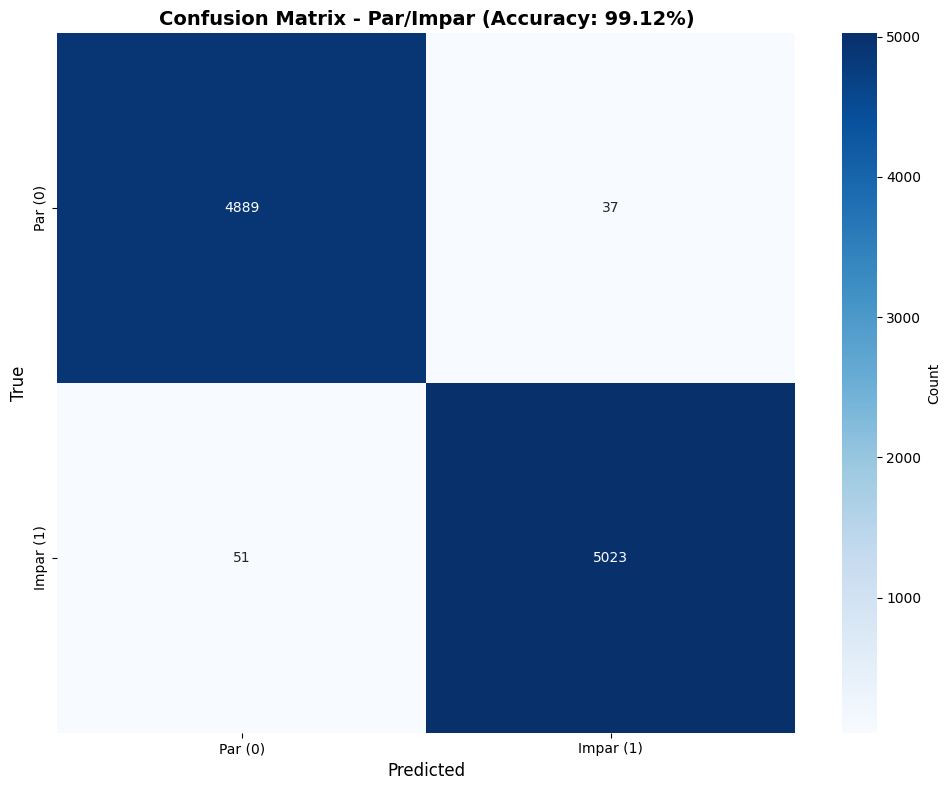

In [13]:
criterion = nn.CrossEntropyLoss()

final_results = evaluate_on_test_set(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {final_results['accuracy']:.2f}%")
print(f"Final Test Loss: {final_results['loss']:.4f}")

# Matriz de confusión
cm = confusion_matrix(final_results['labels'], final_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['Par (0)', 'Impar (1)'],
            yticklabels=['Par (0)', 'Impar (1)'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - Par/Impar (Accuracy: {final_results["accuracy"]:.2f}%)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()